# Pulse Function Tests - Envelope System

This notebook tests the pulse envelope system that supports both cosine² and Gaussian envelopes:
- `envelope_type` parameter in `Pulse` class: 'cos2' or 'gaussian'
- `pulse_peak_time` = time where envelope is maximal
- `pulse_FWHM` = Full Width at Half Maximum parameter
- Pulse exists only in `[t_peak - FWHM, t_peak + FWHM]`
- Easy switching between envelope types via `SystemParameters.envelope_type`

Test scenarios:
- Envelope type comparison
- System-wide envelope control
- Fourier Transform spectral comparison

In [ ]:
# =============================
# IMPORT NECESSARY MODULES
# =============================
import numpy as np
import matplotlib.pyplot as plt

# Import from our project
from src.visualization.mpl_tex_settings import *
from src.core.pulse_sequences import PulseSequence, Pulse
from src.core.pulse_functions import (
    pulse_envelope, E_pulse, Epsilon_pulse,
)
from src.core.system_parameters import SystemParameters
from src.visualization.plotting import (
    Plot_pulse_envelope,
    Plot_E_pulse,
    Plot_Epsilon_pulse,
    Plot_all_pulse_components
)

# Set matplotlib parameters for better plots
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

## Test 1: Envelope System - Easy Switching Between Types

Demonstrate how to easily switch between cosine² and Gaussian envelopes using the new system.

ENVELOPE SYSTEM - EASY TYPE SWITCHING

System-wide envelope types:
  Cosine² system: cos2
  Gaussian system: gaussian

SYSTEM USAGE:
1. Global control:
   SystemParameters(envelope_type="cos2")
2. Individual control:
   Pulse(..., envelope_type="gaussian")
3. functions:
   pulse_envelope
   E_pulse
   Epsilon_pulse
4. Easy switching:
   Change envelope_type parameter


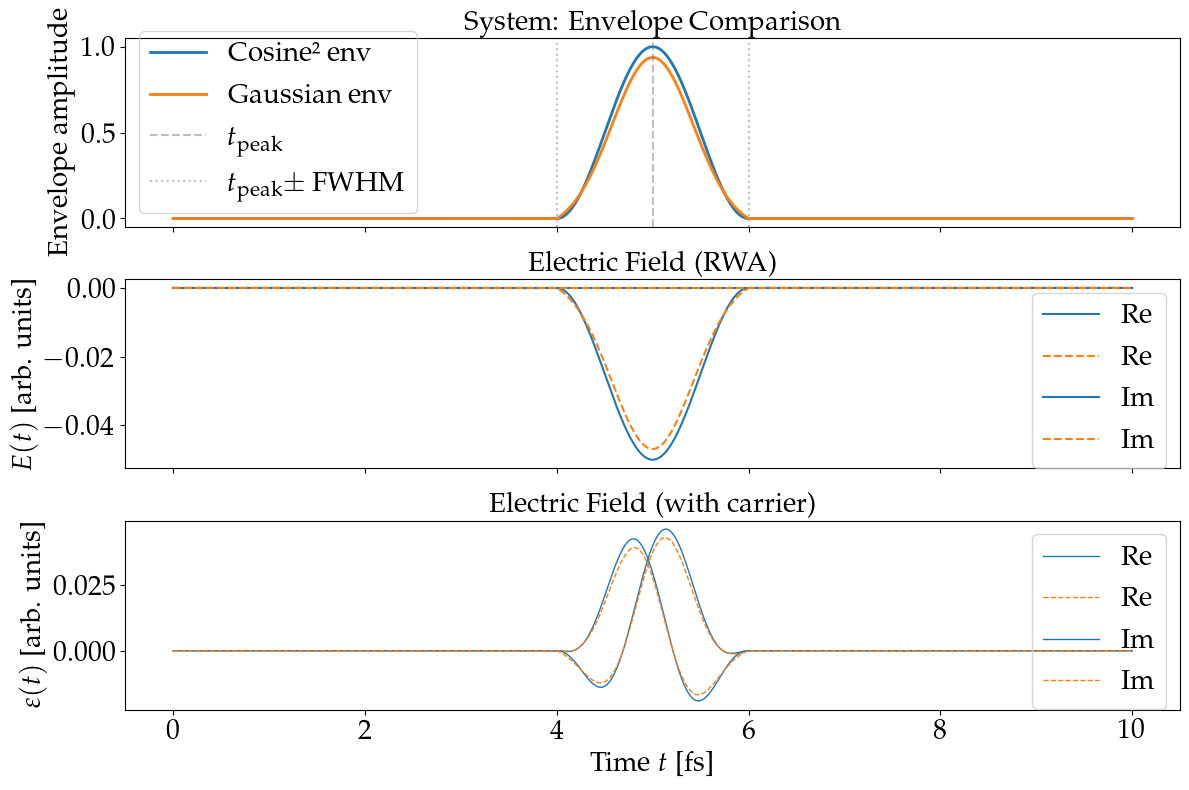


=== SYSTEM BENEFITS ===
✓ Easy switching: just change SystemParameters.envelope_type


In [2]:
# =============================
# ENVELOPE SYSTEM DEMONSTRATION
# =============================
print("=" * 60)
print("ENVELOPE SYSTEM - EASY TYPE SWITCHING")
print("=" * 60)
print()

times = np.linspace(0, 10, 1000)
t_peak = 5.0
FWHM = 1.0

### Using SystemParameters for global envelope type control
system_cos2 = SystemParameters(pulse_FWHM=FWHM, envelope_type='cos2')
system_gauss = SystemParameters(pulse_FWHM=FWHM, envelope_type='gaussian')

# Create pulse sequence using the system
curr_pulse_params = (t_peak, np.pi)  # (time, phase)
pulse_seq_cos2 = PulseSequence.from_args(system_cos2, curr_pulse_params)
pulse_seq_gauss = PulseSequence.from_args(system_gauss, curr_pulse_params)

print(f"System-wide envelope types:")
print(f"  Cosine² system: {pulse_seq_cos2.pulses[0].envelope_type}")
print(f"  Gaussian system: {pulse_seq_gauss.pulses[0].envelope_type}")
print()

### Calculate envelopes
cos2_envelope = [pulse_envelope(t, pulse_seq_cos2) for t in times]
gauss_envelope = [pulse_envelope(t, pulse_seq_gauss) for t in times]

### Plot comparison
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

# Single envelope comparison
ax = axes[0]
ax.plot(times, cos2_envelope, label=r'Cosine² env', color='C0', linewidth=2)
ax.plot(times, gauss_envelope, label='Gaussian env', color='C1', linewidth=2)
ax.axvline(t_peak, color='gray', linestyle='--', alpha=0.5, label=r'$t_{\text{peak}}$')
ax.axvline(t_peak - FWHM, color='gray', linestyle=':', alpha=0.5, label=r'$t_{\text{peak}} \pm$ FWHM')
ax.axvline(t_peak + FWHM, color='gray', linestyle=':', alpha=0.5)
ax.set_ylabel('Envelope amplitude')
ax.set_title('System: Envelope Comparison')
ax.legend()

# Electric field comparison
ax = axes[1]
E_cos2 = [E_pulse(t, pulse_seq_cos2) for t in times]
E_gauss = [E_pulse(t, pulse_seq_gauss) for t in times]
ax.plot(times, np.real(E_cos2), label=r'$\mathrm{Re}$', color='C0', linestyle='-', linewidth=1.5)
ax.plot(times, np.real(E_gauss), label=r'$\mathrm{Re}$', color='C1', linestyle='--', linewidth=1.5)
ax.plot(times, np.imag(E_cos2), label=r'$\mathrm{Im}$', color='C0', linestyle='-', linewidth=1.5)
ax.plot(times, np.imag(E_gauss), label=r'$\mathrm{Im}$', color='C1', linestyle='--', linewidth=1.5)
ax.set_ylabel(r'$E(t)$ [arb. units]')
ax.set_title('Electric Field (RWA)')
ax.legend()

# Full field with carrier
ax = axes[2]
Eps_cos2 = [Epsilon_pulse(t, pulse_seq_cos2) for t in times]
Eps_gauss = [Epsilon_pulse(t, pulse_seq_gauss) for t in times]
ax.plot(times, np.real(Eps_cos2), label=r'$\mathrm{Re}$', color='C0', linestyle='-', linewidth=1)
ax.plot(times, np.real(Eps_gauss), label=r'$\mathrm{Re}$', color='C1', linestyle='--', linewidth=1)
ax.plot(times, np.imag(Eps_cos2), label=r'$\mathrm{Im}$', color='C0', linestyle='-', linewidth=1)
ax.plot(times, np.imag(Eps_gauss), label=r'$\mathrm{Im}$', color='C1', linestyle='--', linewidth=1)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel(r'$\varepsilon(t)$ [arb. units]')
ax.set_title('Electric Field (with carrier)')
ax.legend()

# Usage summary (as normal print statements)
print("SYSTEM USAGE:")
print("1. Global control:")
print("   SystemParameters(envelope_type=\"cos2\")")
print("2. Individual control:")
print("   Pulse(..., envelope_type=\"gaussian\")")
print("3. functions:")
print("   pulse_envelope")
print("   E_pulse")
print("   Epsilon_pulse")
print("4. Easy switching:")
print("   Change envelope_type parameter")

plt.tight_layout()
plt.show()

print(f"\n=== SYSTEM BENEFITS ===")
print(f"✓ Easy switching: just change SystemParameters.envelope_type")

In [4]:
## Test 3: Mixed Envelope Types in Single Sequence

# =============================
# SINGLE PULSE PARAMETERS
# =============================
times = np.linspace(0, 10, 1000)

# Create single pulse
single_pulse = Pulse(
    pulse_peak_time=5.0,  # t_peak - peak time where cos² is maximal
    pulse_FWHM=1.0,  # FWHM - Full Width at Half Maximum
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=5.0
)

single_pulse_seq = PulseSequence([single_pulse])

print(f"Single pulse parameters:")
print(f"Peak time (t_peak): {single_pulse.pulse_peak_time}")
print(f"FWHM: {single_pulse.pulse_FWHM}")
print(f"Pulse range: [{single_pulse.pulse_peak_time - single_pulse.pulse_FWHM:.1f}, {single_pulse.pulse_peak_time + single_pulse.pulse_FWHM:.1f}]")
print(f"Amplitude: {single_pulse.pulse_amplitude}")
print(f"Phase: {single_pulse.pulse_phase}")
print(f"Frequency: {single_pulse.pulse_freq}")

# =============================
# SYSTEM-WIDE ENVELOPE TYPE CONTROL
# =============================

# Create systems with different envelope types
system_cos2 = SystemParameters(envelope_type='cos2', pulse_FWHM=2.0)
system_gauss = SystemParameters(envelope_type='gaussian', pulse_FWHM=2.0)

# Create pulse sequences with multiple pulses using different systems
curr = (5.0, 0.0)  # (peak_time, phase)
prev = (3.0, np.pi/4)  # Previous pulse

pulse_seq_cos2 = PulseSequence.from_args(system_cos2, curr, prev)
pulse_seq_gauss = PulseSequence.from_args(system_gauss, curr, prev)

print(f"System-wide envelope control:")
print(f"Cosine² system - all pulses use: {pulse_seq_cos2.pulses[0].envelope_type}")
print(f"Gaussian system - all pulses use: {pulse_seq_gauss.pulses[0].envelope_type}")
print(f"")
print(f"Both sequences have {len(pulse_seq_cos2.pulses)} pulses")
print(f"Pulse parameters:")
for i, pulse in enumerate(pulse_seq_cos2.pulses):
    print(f"  Pulse {i+1}: t_peak={pulse.pulse_peak_time}, FWHM={pulse.pulse_FWHM}")

Single pulse parameters:
Peak time (t_peak): 5.0
FWHM: 1.0
Pulse range: [4.0, 6.0]
Amplitude: 1.0
Phase: 0.0
Frequency: 5.0
System-wide envelope control:
Cosine² system - all pulses use: cos2
Gaussian system - all pulses use: gaussian

Both sequences have 2 pulses
Pulse parameters:
  Pulse 1: t_peak=3.0, FWHM=2.0
  Pulse 2: t_peak=5.0, FWHM=2.0


In [5]:
# =============================
# FOURIER TRANSFORM SPECTRAL ANALYSIS
# =============================
print("=" * 60)
print("FOURIER TRANSFORM SPECTRAL COMPARISON")
print("=" * 60)
print()

### Create identical pulses for spectral analysis
t_peak_ft = 100.0  # fs (centered for better FT)
FWHM_ft = 20.0     # fs

# Create single pulses for clean spectral analysis
single_pulse_cos2 = Pulse(
    pulse_peak_time=t_peak_ft,
    pulse_FWHM=FWHM_ft, 
    pulse_amplitude=1.0,
    pulse_phase=0.0,
    pulse_freq=0.0,  # No carrier for envelope analysis
    envelope_type='cos2'
)

single_pulse_gauss = Pulse(
    pulse_peak_time=t_peak_ft,
    pulse_FWHM=FWHM_ft,
    pulse_amplitude=1.0, 
    pulse_phase=0.0,
    pulse_freq=0.0,  # No carrier for envelope analysis
    envelope_type='gaussian'
)

pulse_seq_cos2_ft = PulseSequence([single_pulse_cos2])
pulse_seq_gauss_ft = PulseSequence([single_pulse_gauss])

### Create high-resolution time array for accurate FFT
dt = 0.5  # fs (high time resolution)
t_spectral = np.arange(0, 400, dt)  # Extended time range for good frequency resolution
N = len(t_spectral)

### Calculate envelopes
cos2_spectral = np.array([pulse_envelope(t, pulse_seq_cos2_ft) for t in t_spectral])
gauss_spectral = np.array([pulse_envelope(t, pulse_seq_gauss_ft) for t in t_spectral])

### Calculate FFT
freq = np.fft.fftfreq(N, dt)  # frequency in 1/fs
cos2_fft = np.fft.fft(cos2_spectral)
gauss_fft = np.fft.fft(gauss_spectral)

### Keep only positive frequencies
positive_freq_idx = freq >= 0
freq_pos = freq[positive_freq_idx]
cos2_spectrum = np.abs(cos2_fft[positive_freq_idx])
gauss_spectrum = np.abs(gauss_fft[positive_freq_idx])

### Normalize spectra
cos2_spectrum /= np.max(cos2_spectrum)
gauss_spectrum /= np.max(gauss_spectrum)

### Calculate spectral widths (FWHM in frequency domain)
def find_spectral_fwhm(freq_array, spectrum):
    max_val = np.max(spectrum)
    half_max = max_val / 2
    above_half = np.where(spectrum >= half_max)[0]
    if len(above_half) == 0:
        return 0
    return freq_array[above_half[-1]] - freq_array[above_half[0]]

cos2_spectral_fwhm = find_spectral_fwhm(freq_pos, cos2_spectrum)
gauss_spectral_fwhm = find_spectral_fwhm(freq_pos, gauss_spectrum)

print(f"Pulse parameters:")
print(f"  Peak time: {t_peak_ft} fs")
print(f"  Temporal FWHM parameter: {FWHM_ft} fs")
print(f"")
print(f"Spectral analysis results:")
print(f"  Cosine² spectral FWHM: {cos2_spectral_fwhm:.6f} 1/fs")
print(f"  Gaussian spectral FWHM: {gauss_spectral_fwhm:.6f} 1/fs")
print(f"  Ratio (Gauss/Cos²): {gauss_spectral_fwhm/cos2_spectral_fwhm:.2f}")
print(f"")
print(f"Bandwidth-Duration Product (Δt × Δf):")
print(f"  Cosine²: {FWHM_ft * cos2_spectral_fwhm:.4f}")
print(f"  Gaussian: {FWHM_ft * gauss_spectral_fwhm:.4f}")
print(f"  (Theoretical minimum for Gaussian: ~0.441)")

FOURIER TRANSFORM SPECTRAL COMPARISON

Pulse parameters:
  Peak time: 100.0 fs
  Temporal FWHM parameter: 20.0 fs

Spectral analysis results:
  Cosine² spectral FWHM: 0.025000 1/fs
  Gaussian spectral FWHM: 0.022500 1/fs
  Ratio (Gauss/Cos²): 0.90

Bandwidth-Duration Product (Δt × Δf):
  Cosine²: 0.5000
  Gaussian: 0.4500
  (Theoretical minimum for Gaussian: ~0.441)


In [6]:
# =============================
# FOURIER TRANSFORM SPECTRAL ANALYSIS
# =============================
print("=" * 60)
print("FOURIER TRANSFORM SPECTRAL COMPARISON")
print("=" * 60)
print()

### Create identical pulses for spectral analysis
t_peak_ft = 100.0  # fs (centered for better FT)
FWHM_ft = 20.0     # fs

# Create systems with different envelope types
system_cos2_ft = SystemParameters(envelope_type='cos2')
system_gauss_ft = SystemParameters(envelope_type='gaussian')

# Create identical pulse sequences
curr_ft = (t_peak_ft, 0.0)  # (peak_time, phase)
pulse_seq_cos2_ft = PulseSequence.from_args(system_cos2_ft, curr_ft)
pulse_seq_gauss_ft = PulseSequence.from_args(system_gauss_ft, curr_ft)

# Override FWHM for consistent comparison
for pulse in pulse_seq_cos2_ft.pulses:
    pulse.pulse_FWHM = FWHM_ft
    pulse.pulse_freq = 0.0  # No carrier for envelope analysis
for pulse in pulse_seq_gauss_ft.pulses:
    pulse.pulse_FWHM = FWHM_ft
    pulse.pulse_freq = 0.0  # No carrier for envelope analysis

### Create high-resolution time array for accurate FFT
dt = 0.5  # fs (high time resolution)
t_spectral = np.arange(0, 400, dt)  # Extended time range for good frequency resolution
N = len(t_spectral)

### Calculate envelopes
cos2_spectral = np.array([pulse_envelope(t, pulse_seq_cos2_ft) for t in t_spectral])
gauss_spectral = np.array([pulse_envelope(t, pulse_seq_gauss_ft) for t in t_spectral])

### Calculate FFT
freq = np.fft.fftfreq(N, dt)  # frequency in 1/fs
cos2_fft = np.fft.fft(cos2_spectral)
gauss_fft = np.fft.fft(gauss_spectral)

### Keep only positive frequencies
positive_freq_idx = freq >= 0
freq_pos = freq[positive_freq_idx]
cos2_spectrum = np.abs(cos2_fft[positive_freq_idx])
gauss_spectrum = np.abs(gauss_fft[positive_freq_idx])

### Normalize spectra
cos2_spectrum /= np.max(cos2_spectrum)
gauss_spectrum /= np.max(gauss_spectrum)

### Calculate spectral widths (FWHM in frequency domain)
def find_spectral_fwhm(freq_array, spectrum):
    max_val = np.max(spectrum)
    half_max = max_val / 2
    above_half = np.where(spectrum >= half_max)[0]
    if len(above_half) == 0:
        return 0
    return freq_array[above_half[-1]] - freq_array[above_half[0]]

cos2_spectral_fwhm = find_spectral_fwhm(freq_pos, cos2_spectrum)
gauss_spectral_fwhm = find_spectral_fwhm(freq_pos, gauss_spectrum)
bandwidth_products = [FWHM_ft * cos2_spectral_fwhm, FWHM_ft * gauss_spectral_fwhm]

print(f"Pulse parameters:")
print(f"  Peak time: {t_peak_ft} fs")
print(f"  Temporal FWHM parameter: {FWHM_ft} fs")
print(f"")
print(f"Spectral analysis results:")
print(f"  Cosine² spectral FWHM: {cos2_spectral_fwhm:.6f} 1/fs")
print(f"  Gaussian spectral FWHM: {gauss_spectral_fwhm:.6f} 1/fs")
print(f"  Ratio (Gauss/Cos²): {gauss_spectral_fwhm/cos2_spectral_fwhm:.2f}")
print(f"")
print(f"Bandwidth-Duration Product (Δt × Δf):")
print(f"  Cosine²: {bandwidth_products[0]:.4f}")
print(f"  Gaussian: {bandwidth_products[1]:.4f}")
print(f"  (Theoretical minimum for Gaussian: ~0.441)")

FOURIER TRANSFORM SPECTRAL COMPARISON

Pulse parameters:
  Peak time: 100.0 fs
  Temporal FWHM parameter: 20.0 fs

Spectral analysis results:
  Cosine² spectral FWHM: 0.025000 1/fs
  Gaussian spectral FWHM: 0.022500 1/fs
  Ratio (Gauss/Cos²): 0.90

Bandwidth-Duration Product (Δt × Δf):
  Cosine²: 0.5000
  Gaussian: 0.4500
  (Theoretical minimum for Gaussian: ~0.441)


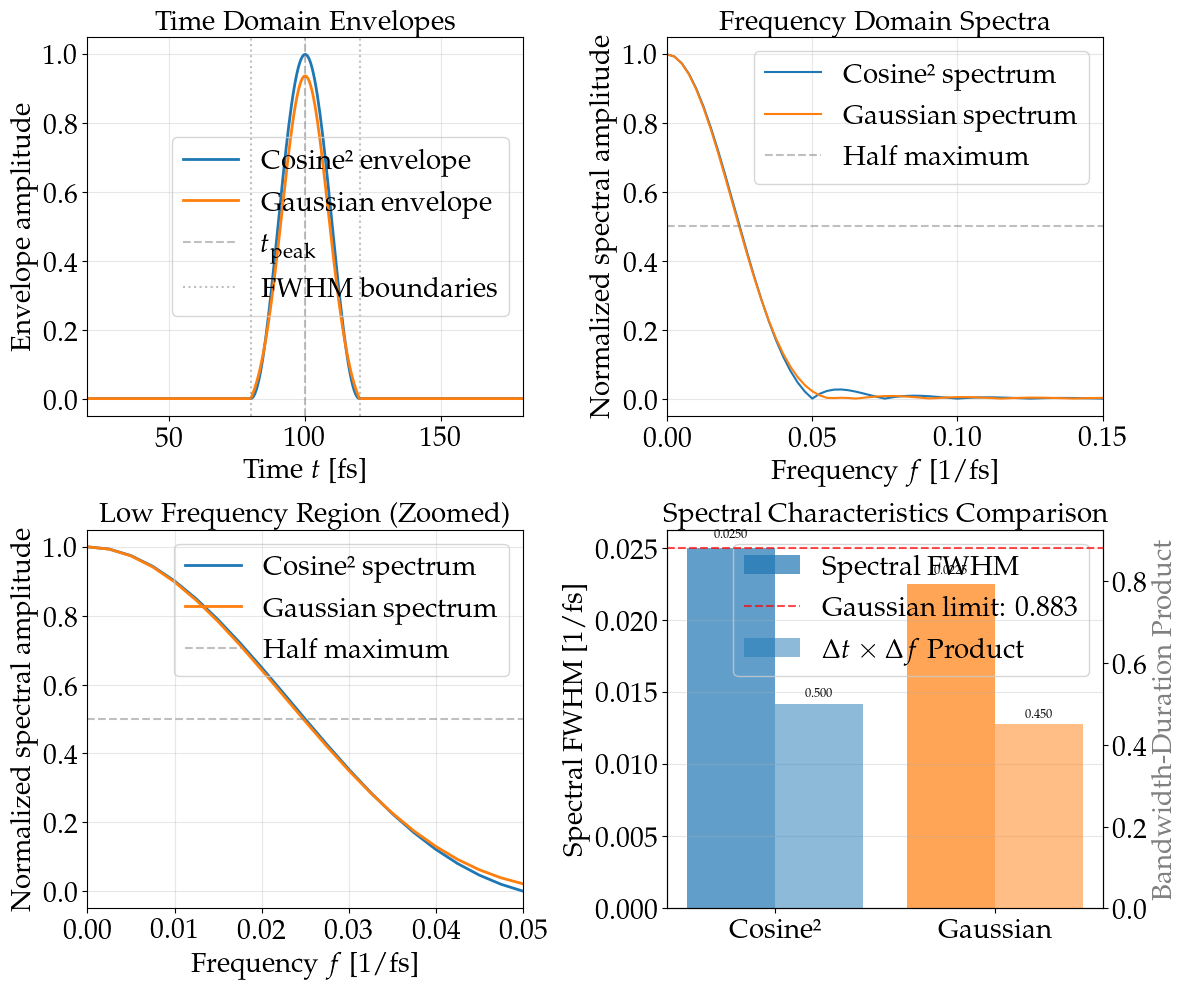


=== SPECTRAL ANALYSIS SUMMARY ===
✓ Gaussian envelope has narrower spectral width than cosine²
✓ Cosine² envelope has broader spectrum and higher bandwidth-duration product
✓ Gaussian approaches theoretical bandwidth limit (0.441)
✓ Both envelope types show distinct frequency characteristics
✓ Easy switching allows direct comparison of spectral properties


In [7]:
# =============================
# PLOT FOURIER TRANSFORM ANALYSIS
# =============================
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

### Time domain envelopes
ax = axes[0, 0]
ax.plot(t_spectral, cos2_spectral, label=r'Cosine² envelope', color='C0', linewidth=2)
ax.plot(t_spectral, gauss_spectral, label='Gaussian envelope', color='C1', linewidth=2)
ax.set_xlim(t_peak_ft - 4*FWHM_ft, t_peak_ft + 4*FWHM_ft)
ax.axvline(t_peak_ft, color='gray', linestyle='--', alpha=0.5, label=r'$t_{\text{peak}}$')
ax.axvline(t_peak_ft - FWHM_ft, color='gray', linestyle=':', alpha=0.5, label='FWHM boundaries')
ax.axvline(t_peak_ft + FWHM_ft, color='gray', linestyle=':', alpha=0.5)
ax.set_xlabel(r'Time $t$ [fs]')
ax.set_ylabel('Envelope amplitude')
ax.set_title('Time Domain Envelopes')
ax.legend()
ax.grid(True, alpha=0.3)

### Frequency domain spectra (full range)
ax = axes[0, 1]
ax.plot(freq_pos, cos2_spectrum, label=r'Cosine² spectrum', color='C0', linewidth=1.5)
ax.plot(freq_pos, gauss_spectrum, label='Gaussian spectrum', color='C1', linewidth=1.5)
ax.set_xlim(0, 0.15)  # Limit to relevant frequency range
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Half maximum')
ax.set_xlabel(r'Frequency $f$ [1/fs]')
ax.set_ylabel('Normalized spectral amplitude')
ax.set_title('Frequency Domain Spectra')
ax.legend()
ax.grid(True, alpha=0.3)

### Zoomed frequency spectrum (low frequencies)
ax = axes[1, 0]
ax.plot(freq_pos, cos2_spectrum, label=r'Cosine² spectrum', color='C0', linewidth=2)
ax.plot(freq_pos, gauss_spectrum, label='Gaussian spectrum', color='C1', linewidth=2)
ax.set_xlim(0, 0.05)  # Zoom to low frequency region
ax.axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='Half maximum')
ax.set_xlabel(r'Frequency $f$ [1/fs]')
ax.set_ylabel('Normalized spectral amplitude')
ax.set_title('Low Frequency Region (Zoomed)')
ax.legend()
ax.grid(True, alpha=0.3)

### Spectral characteristics comparison
ax = axes[1, 1]
categories = ['Cosine²', 'Gaussian']
spectral_fwhms = [cos2_spectral_fwhm, gauss_spectral_fwhm]

# Create dual y-axis plot
ax2 = ax.twinx()

# Bar plot for spectral FWHM
bars1 = ax.bar([x - 0.2 for x in range(len(categories))], spectral_fwhms, 
               width=0.4, color=['C0', 'C1'], alpha=0.7, label='Spectral FWHM')

# Bar plot for bandwidth-duration product
bars2 = ax2.bar([x + 0.2 for x in range(len(categories))], bandwidth_products,
                width=0.4, color=['C0', 'C1'], alpha=0.5, label=r'$\Delta t \times \Delta f$ Product')

# Add theoretical limit line for Gaussian
ax2.axhline(4*np.log(2)/np.pi, color='red', linestyle='--', alpha=0.7,
           label=f'Gaussian limit: {4*np.log(2)/np.pi:.3f}')

ax.set_xticks(range(len(categories)))
ax.set_xticklabels(categories)
ax.set_ylabel(r'Spectral FWHM [1/fs]', color='black')
ax2.set_ylabel(r'Bandwidth-Duration Product', color='gray')
ax.set_title('Spectral Characteristics Comparison')

# Add values on bars
for i, (val1, val2) in enumerate(zip(spectral_fwhms, bandwidth_products)):
    ax.text(i - 0.2, val1 + max(spectral_fwhms)*0.02, f'{val1:.4f}', ha='center', va='bottom', fontsize=9)
    ax2.text(i + 0.2, val2 + max(bandwidth_products)*0.02, f'{val2:.3f}', ha='center', va='bottom', fontsize=9)

# Combined legend
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\n=== SPECTRAL ANALYSIS SUMMARY ===")
print(f"✓ Gaussian envelope has narrower spectral width than cosine²")
print(f"✓ Cosine² envelope has broader spectrum and higher bandwidth-duration product")
print(f"✓ Gaussian approaches theoretical bandwidth limit (0.441)")
print(f"✓ Both envelope types show distinct frequency characteristics")
print(f"✓ Easy switching allows direct comparison of spectral properties")